##Установка пакетов и импорт библиотек

In [1]:
!pip install -q torchmetrics[detection]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 11.0 MB/s eta 0:00:00


In [2]:
from torchmetrics.detection import MeanAveragePrecision, IntersectionOverUnion
from torchmetrics.functional.detection import intersection_over_union
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pycocotools.coco import COCO
import time
from tqdm import tqdm
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models
import torchvision.transforms.v2 as transforms

from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image, ImageReadMode

from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.models.detection import SSD300_VGG16_Weights
from torch import nn
from torchvision.ops import box_iou, complete_box_iou, complete_box_iou_loss

plt.ion()

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Глобальные переменные и пути к данным

In [5]:
TRAIN_SIZE = .75
BATCH_SIZE = 8
IMG_SIZE = 300
NUM_EPOCHS = 15
generator = torch.Generator().manual_seed(2612)
dataDir = 'drive/MyDrive/Colab Notebooks/aviavision/data/Images/'
addDir = 'drive/MyDrive/Colab Notebooks/aviavision/data/add_img/'
modelDir = 'drive/MyDrive/Colab Notebooks/aviavision/data/models/'
ann_path = 'drive/MyDrive/Colab Notebooks/aviavision/data/Annotations/instances_default.json'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка аннотаций из Coco датасета

In [7]:
coco = COCO(ann_path)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

loading annotations into memory...
Done (t=1.36s)
creating index...
index created!
COCO categories: 
flame



## Трансформации и аугментации



In [8]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # transforms.RandomAdjustSharpness(sharpness_factor=1.1),
    # transforms.RandomInvert()
    ])

## Класс датасета

In [9]:
class FireDataset(torch.utils.data.Dataset):
    def __init__(self, root, coco, size, transform=None):
        self.root = root
        self.transforms = transform
        self.coco = coco
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.size = size

    def __getitem__(self, index):
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = self.coco.loadAnns(ann_ids)

        # open the input image
        path = self.coco.loadImgs(img_id)[0]["file_name"]
        img = Image.open(os.path.join(self.root, path))
        kx = self.size / img.size[0]
        ky = self.size / img.size[1]

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height] (Upper-Left)
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            width = coco_annotation[i]['bbox'][2]
            height = coco_annotation[i]['bbox'][3]

            n_xmin = xmin * kx
            n_ymin = ymin * ky
            n_xmax = n_xmin + width * kx
            n_ymax = n_ymin + height * ky

            boxes.append([n_xmin, n_ymin, n_xmax, n_ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor([ann["category_id"] for ann in coco_annotation], dtype=torch.int64)

        # Annotation is in dictionary format
        new_annotation = {}
        new_annotation["boxes"] = boxes
        new_annotation["labels"] = labels

        if self.transforms is not None:
            img = self.transforms(img)

        return img, new_annotation

    def __len__(self):
        return len(self.ids)

imgs = FireDataset(root=dataDir, coco=coco, size=IMG_SIZE, transform=transformer)

## Загрузчики

In [10]:
test_size = int(.1 * len(imgs))
train_size_1 = len(imgs) - test_size
train_size = int(TRAIN_SIZE * train_size_1)
valid_size = train_size_1 - train_size

train_dataset, test_dataset = torch.utils.data.random_split(imgs, [train_size_1, test_size], generator=generator)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size], generator=generator)
dataset_list = {'train': train_dataset, 'val': valid_dataset}
dataset_sizes = {'train': train_size, 'val': valid_size}
dataloaders = {x: torch.utils.data.DataLoader(dataset_list[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=0, collate_fn=lambda batch: tuple(zip(*batch))) for x in ['train', 'val']}


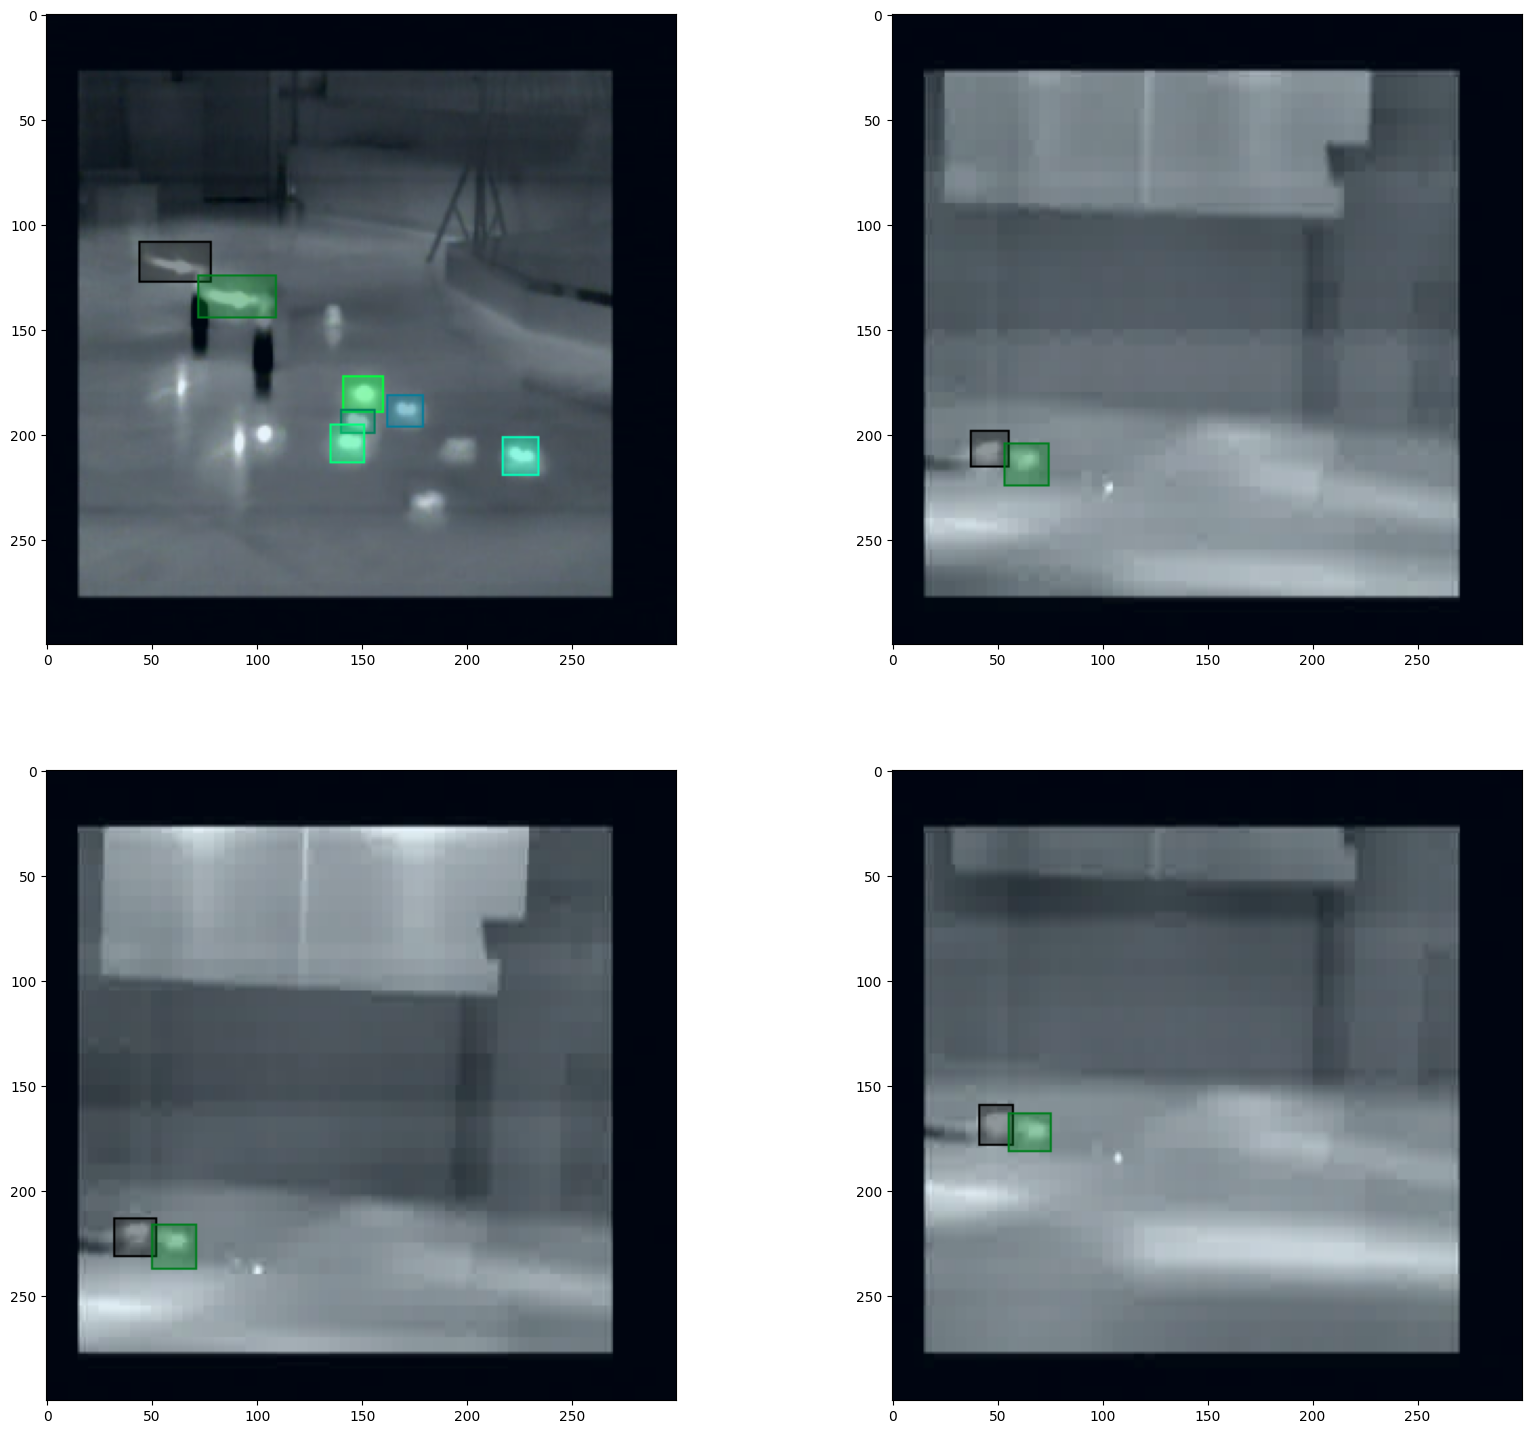

In [11]:
idx = np.random.randint(0, len(imgs), 4)

fig = plt.figure(figsize=(20,18))
for i in range(len(idx)):
  fig.add_subplot(2, 2, i+1)
  data = imgs[idx[i]]
  look = data[0]
  look = (255.0 * (look - look.min()) / (look.max() - look.min())).to(torch.uint8)
  boxes = data[1]['boxes']
  look = draw_bounding_boxes(look, boxes, fill=True, width=1)
  plt.imshow(look.permute(1, 2, 0))
plt.show()

## Загрузка и кастомизация модели
**Подходят любые модели, которые понимают вот такой формат данных на входе:**

```
        boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.

        labels (Int64Tensor[N]): the class label for each ground-truth box

```

**SSD300-VGG16**

In [32]:
ssd = models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT, weights_backbone=models.VGG16_Weights, pretrained=True, score_thresh = .25)

In [33]:
def create_model(model, num_classes=91, size=IMG_SIZE):

   in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
   num_anchors = model.anchor_generator.num_anchors_per_location()
   model.head.classification_head = SSDClassificationHead(
       in_channels=in_channels,
       num_anchors=num_anchors,
       num_classes=num_classes,
   )
    # Image size for transforms.
   model.transform.min_size = (size,)
   model.transform.max_size = size
   return model

model = create_model(ssd, 2, IMG_SIZE)


## Вспомогательные классы для осреднения результата и сохранения лучшей модели

In [14]:
class Averager:
    def __init__(self):
      self.current_total = 0.0
      self.iterations = 0.0

    def send(self, value):
      self.current_total += value
      self.iterations += 1

    @property
    def value(self):
      if self.iterations == 0:
        return 0
      else:
        return 1.0 * self.current_total / self.iterations

    def reset(self):
      self.current_total = 0.0
      self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer
    ):
      if current_valid_loss < self.best_valid_loss:
        self.best_valid_loss = current_valid_loss
        print(f"\nBest validation loss: {self.best_valid_loss}")
        print(f"\nSaving best model for epoch: {epoch+1}\n")
        name = 'size_' + str(IMG_SIZE) + '_epochs_' + str(NUM_EPOCHS) + '_ssd.pth'
        torch.save(model.state_dict(), modelDir + name)

## Функции для обучения и валидации

In [15]:
def train(train_data_loader, model):
  model.train()
  print('Training')
  global train_itr
  global train_loss_list

     # initialize tqdm progress bar
  prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

  for i, data in enumerate(prog_bar):
    optimizer.zero_grad()
    images, targets = data

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()
    train_loss_list.append(loss_value)
    train_loss_hist.send(loss_value)
    losses.backward()
    optimizer.step()
    train_itr += 1

        # update the loss value beside the progress bar for each iteration
    prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
  return train_loss_list

In [16]:
def validate(valid_data_loader, model):
  print('Validating')
  global val_itr
  global val_loss_list
  #global map_list

    # initialize tqdm progress bar
  prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

  for i, data in enumerate(prog_bar):
    images, targets = data

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
      model.train()
      loss_dict = model(images, targets)
      metric = MeanAveragePrecision(iou_type="bbox")
      model.eval()
      output = model(images, targets)
      metric.update(output, targets)
      map_50 = metric.compute()['map_50']

    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()
    val_loss_list.append(loss_value)
    #map_list.append(map_50)
    #map_hist.send(map_50)
    val_loss_hist.send(loss_value)
    val_itr += 1
    # update the loss value beside the progress bar for each iteration
    prog_bar.set_description(desc=f"Loss: {loss_value:.4f}---mAP50: {map_50:.4f}")
  return val_loss_list

## Обучение

In [17]:
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = model.to(device)
train_loss_hist = Averager()
val_loss_hist = Averager()
#map_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []
#map_list = []
save_best_model = SaveBestModel()
# name to save the trained model with

# start the training epochs
for epoch in range(NUM_EPOCHS):
  print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
  # reset the training and validation loss histories for the current epoch
  train_loss_hist.reset()
  val_loss_hist.reset()
  # start timer and carry out training and validation
  start = time.time()
  train_loss = train(dataloaders['train'], model)
  val_loss = validate(dataloaders['val'], model)
  print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
  print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
  end = time.time()
  print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
  # save the best model till now if we have the least loss in the...
  # ... current epoch
  save_best_model(
            val_loss_hist.value, epoch, model, optimizer
        )


EPOCH 1 of 15
Training


Loss: 3.2928: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]


Validating


Loss: 3.0767---mAP50: 0.0000: 100%|██████████| 13/13 [00:55<00:00,  4.23s/it]


Epoch #1 train loss: 4.296
Epoch #1 validation loss: 3.131
Took 3.327 minutes for epoch 1

Best validation loss: 3.13071162884052

Saving best model for epoch: 1


EPOCH 2 of 15
Training


Loss: 2.6208: 100%|██████████| 37/37 [00:10<00:00,  3.56it/s]


Validating


Loss: 2.9304---mAP50: 0.1287: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch #2 train loss: 2.805
Epoch #2 validation loss: 2.699
Took 0.248 minutes for epoch 2

Best validation loss: 2.6988054789029636

Saving best model for epoch: 2


EPOCH 3 of 15
Training


Loss: 2.4067: 100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Validating


Loss: 2.5032---mAP50: 1.0000: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


Epoch #3 train loss: 2.427
Epoch #3 validation loss: 2.416
Took 0.289 minutes for epoch 3

Best validation loss: 2.416314932016226

Saving best model for epoch: 3


EPOCH 4 of 15
Training


Loss: 2.3527: 100%|██████████| 37/37 [00:10<00:00,  3.59it/s]


Validating


Loss: 2.3727---mAP50: 1.0000: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch #4 train loss: 2.152
Epoch #4 validation loss: 2.248
Took 0.243 minutes for epoch 4

Best validation loss: 2.248286944169265

Saving best model for epoch: 4


EPOCH 5 of 15
Training


Loss: 1.9381: 100%|██████████| 37/37 [00:10<00:00,  3.65it/s]


Validating


Loss: 2.2316---mAP50: 1.0000: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch #5 train loss: 1.970
Epoch #5 validation loss: 2.178
Took 0.240 minutes for epoch 5

Best validation loss: 2.1780506647550144

Saving best model for epoch: 5


EPOCH 6 of 15
Training


Loss: 1.8786: 100%|██████████| 37/37 [00:10<00:00,  3.44it/s]


Validating


Loss: 1.9522---mAP50: 0.9208: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch #6 train loss: 1.822
Epoch #6 validation loss: 2.114
Took 0.248 minutes for epoch 6

Best validation loss: 2.1140885811585646

Saving best model for epoch: 6


EPOCH 7 of 15
Training


Loss: 1.6962: 100%|██████████| 37/37 [00:10<00:00,  3.70it/s]


Validating


Loss: 1.9438---mAP50: 0.8713: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch #7 train loss: 1.690
Epoch #7 validation loss: 2.043
Took 0.237 minutes for epoch 7

Best validation loss: 2.042923927307129

Saving best model for epoch: 7


EPOCH 8 of 15
Training


Loss: 1.5420: 100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Validating


Loss: 2.1038---mAP50: 0.7525: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch #8 train loss: 1.607
Epoch #8 validation loss: 2.046
Took 0.236 minutes for epoch 8

EPOCH 9 of 15
Training


Loss: 1.5865: 100%|██████████| 37/37 [00:09<00:00,  3.73it/s]


Validating


Loss: 1.8471---mAP50: 1.0000: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch #9 train loss: 1.489
Epoch #9 validation loss: 2.041
Took 0.234 minutes for epoch 9

Best validation loss: 2.0410940188627977

Saving best model for epoch: 9


EPOCH 10 of 15
Training


Loss: 1.4782: 100%|██████████| 37/37 [00:10<00:00,  3.48it/s]


Validating


Loss: 2.1789---mAP50: 1.0000: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


Epoch #10 train loss: 1.377
Epoch #10 validation loss: 2.077
Took 0.265 minutes for epoch 10

EPOCH 11 of 15
Training


Loss: 1.4567: 100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Validating


Loss: 2.0854---mAP50: 1.0000: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch #11 train loss: 1.260
Epoch #11 validation loss: 2.055
Took 0.256 minutes for epoch 11

EPOCH 12 of 15
Training


Loss: 1.1168: 100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Validating


Loss: 1.6628---mAP50: 0.9208: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch #12 train loss: 1.174
Epoch #12 validation loss: 2.082
Took 0.235 minutes for epoch 12

EPOCH 13 of 15
Training


Loss: 1.0002: 100%|██████████| 37/37 [00:10<00:00,  3.57it/s]


Validating


Loss: 1.7892---mAP50: 1.0000: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


Epoch #13 train loss: 1.070
Epoch #13 validation loss: 2.142
Took 0.250 minutes for epoch 13

EPOCH 14 of 15
Training


Loss: 0.8360: 100%|██████████| 37/37 [00:10<00:00,  3.54it/s]


Validating


Loss: 1.7053---mAP50: 0.8713: 100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


Epoch #14 train loss: 0.931
Epoch #14 validation loss: 2.153
Took 0.268 minutes for epoch 14

EPOCH 15 of 15
Training


Loss: 0.7447: 100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Validating


Loss: 2.3826---mAP50: 1.0000: 100%|██████████| 13/13 [00:04<00:00,  3.00it/s]

Epoch #15 train loss: 0.813
Epoch #15 validation loss: 2.246
Took 0.262 minutes for epoch 15


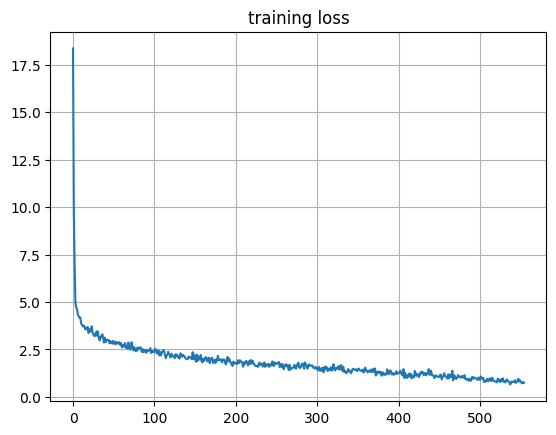

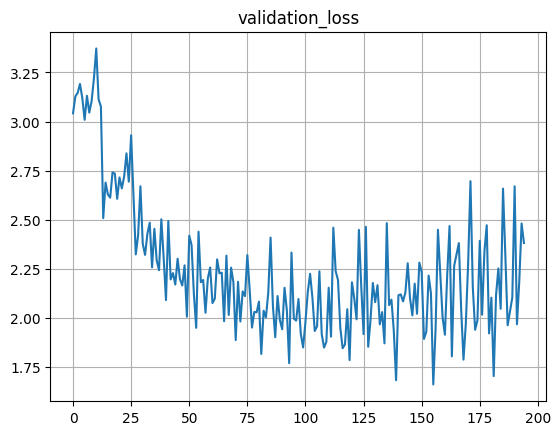

In [18]:
plt.plot(train_loss)
plt.grid()
plt.title('training loss')
plt.show()
plt.plot(val_loss)
plt.grid()
plt.title('validation_loss')
plt.show()

## Загрузка весов лучшей из моделей

In [51]:
name = 'size_' + str(IMG_SIZE) + '_epochs_' + str(NUM_EPOCHS) + '_ssd.pth'

best_model_params_path = os.path.join(modelDir, name)
trained_model = model
# trained_model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device('cpu')))
trained_model.load_state_dict(torch.load(best_model_params_path))
trained_model = trained_model.to(device)

## Функция для рисования картинок и границ объектов

In [52]:
def draw(input, model):
  image = input[0]
  with torch.no_grad():
    x = image.to(device)
    predictions = trained_model.eval()([x, ])
  pred = predictions[0]
  # print(pred)
  image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
  #pred_score = [f"value: {score:.3f}" for score in pred["scores"]]
  pred_label = [f"predicted fire" for label in pred["labels"]]
  true_label = [f"true fire" for label in input[1]["labels"]]
  pred_boxes = pred["boxes"].long()
  true_boxes = input[1]['boxes'].long()
  output_image = draw_bounding_boxes(image, pred_boxes, fill=True, colors=['blue']*len(pred_label), width=1)
  output_image = draw_bounding_boxes(output_image, true_boxes, fill=False, colors=['red']*len(true_label), width=1)
  targets = [{k: v.to(device) for k, v in t.items()} for t in [input[1], ]]
  metric = MeanAveragePrecision(iou_type="bbox")
  metric.update(predictions, targets)
  map_50 = metric.compute()['map_50']


  return output_image, map_50

## Проверка на изображениях из тестового датасета

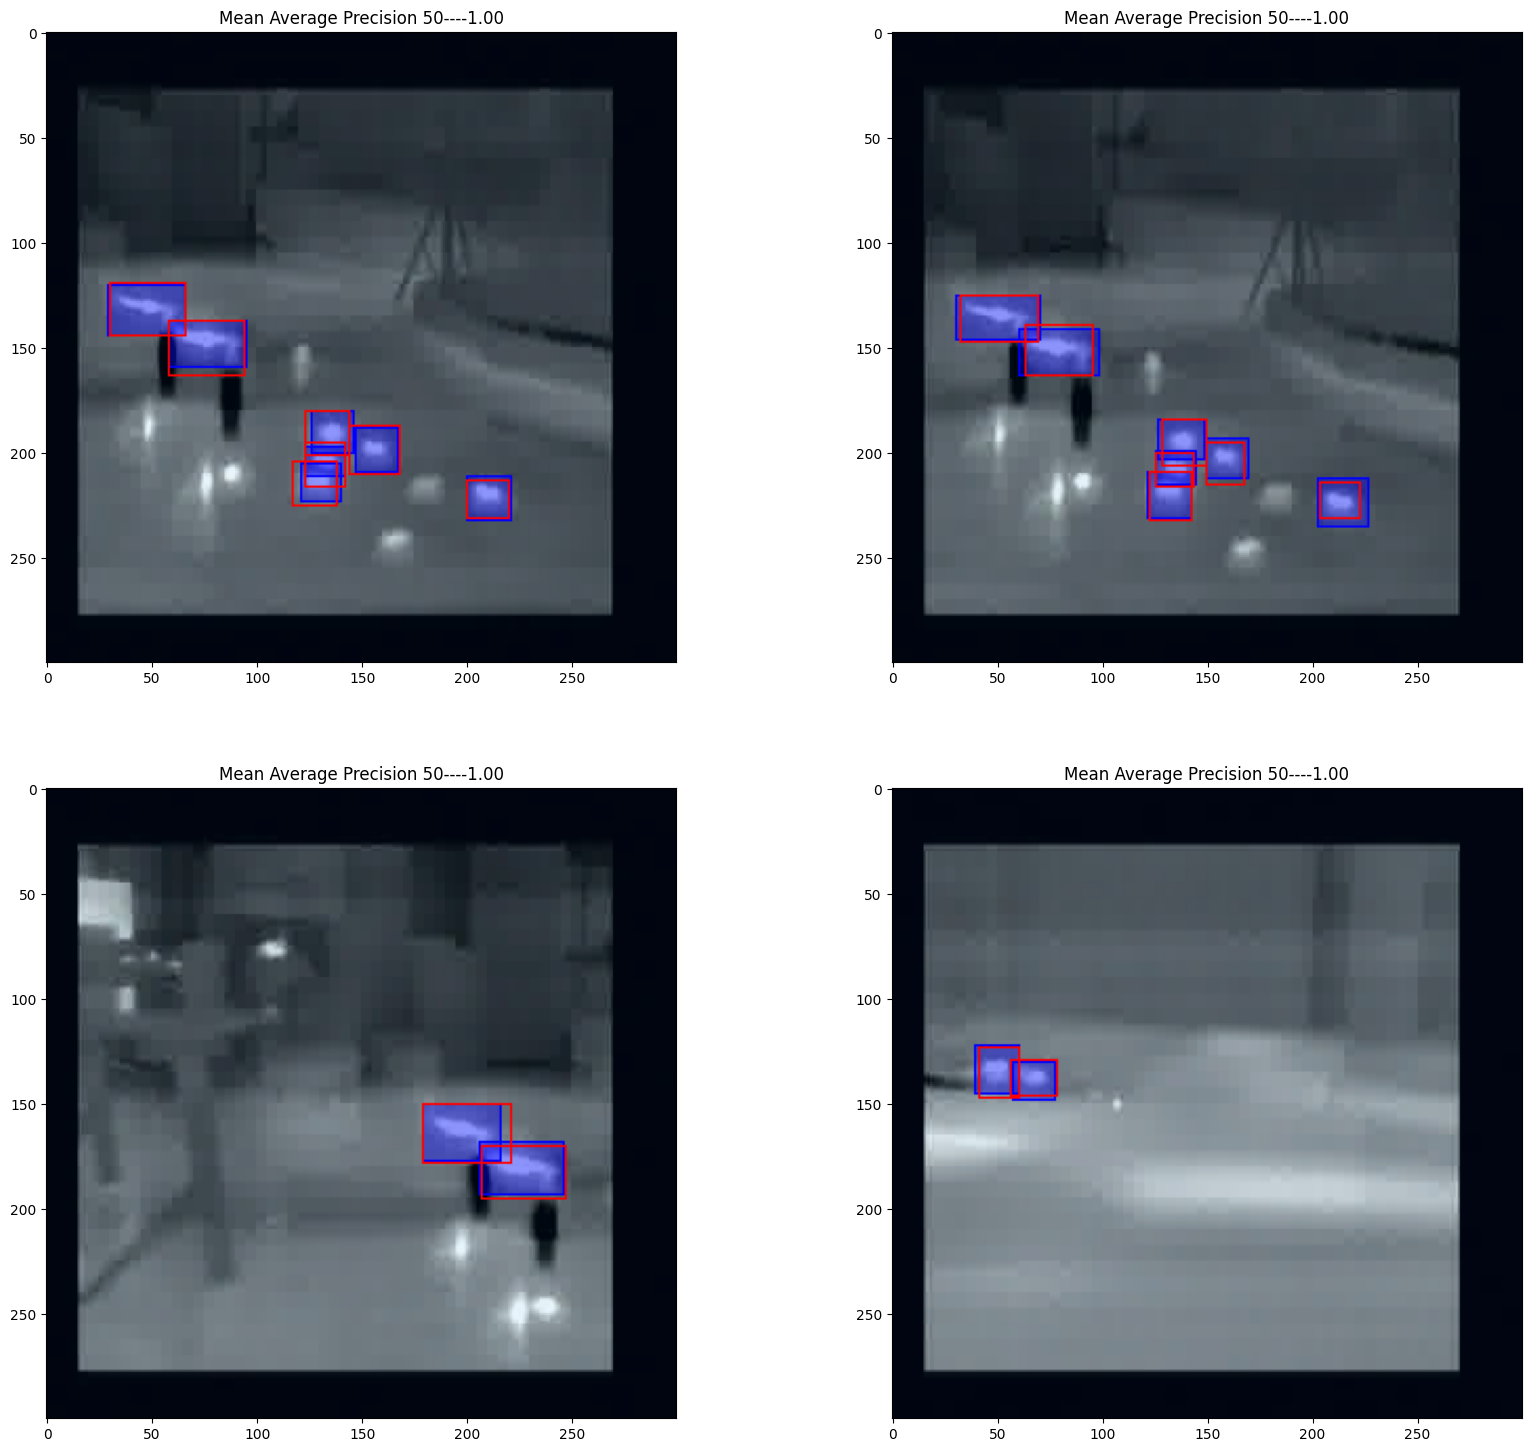

In [53]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

idx = np.random.randint(0, len(test_dataset), 4)
fig = plt.figure(figsize=(20,18))

for i in range(len(idx)):
  data = test_dataset[idx[i]]
  look, MaP = draw(data, trained_model)
  fig.add_subplot(2, 2, i+1).set_title((f'Mean Average Precision 50----{MaP:.2f}'))
  plt.imshow(look.permute(1, 2, 0))
plt.show()

## Среднее значение метрики

In [25]:
result = []
for data in test_dataset:
  _, metric = draw(data, trained_model)
  result.append(metric)
print(sum(result) / len(result))

tensor(0.9643)
